In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
import os.path
import seaborn as sns
from sklearn.metrics import confusion_matrix

#dane wejściowe z linku https://www.kaggle.com/prasunroy/natural-images

In [2]:
#wizualizacja danych wej. 
dir = Path('./dataset/') #ścieżka
filepaths = list(dir.glob(r'**/*.jpg'))

In [5]:
def proc_img(filepath):
    
    labels = [str(filepath[i]).split('\\')[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures: 6899

Number of different labels: 8

Labels: ['person' 'dog' 'cat' 'fruit' 'motorbike' 'airplane' 'car' 'flower']


,Filepath,Label
0,dataset\natural_images\person\person_0708.jpg,person
1,dataset\natural_images\dog\dog_0120.jpg,dog
2,dataset\natural_images\cat\cat_0613.jpg,cat
3,dataset\natural_images\fruit\fruit_0759.jpg,fruit
4,dataset\natural_images\dog\dog_0189.jpg,dog


In [6]:
df['Label'].value_counts()

fruit        1000
person        986
car           968
cat           885
flower        843
motorbike     788
airplane      727
dog           702
Name: Label, dtype: int64

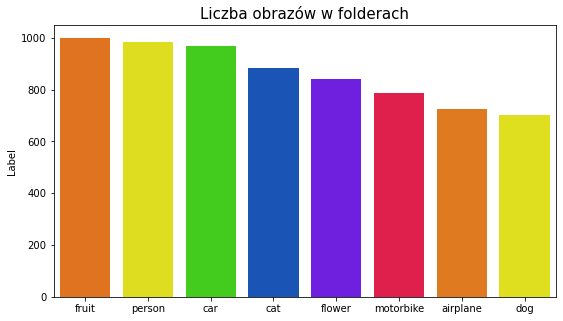

In [79]:
#wykres danych wejściowych
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "prism")
plt.title("Liczba obrazów w folderach", fontsize = 15)
plt.show()

In [80]:
#generator danych wykorzystywany do tworzenia pozdbioru uczącego oraz walidacyjnego
datagen = ImageDataGenerator(rescale = 1./255, #wartości z zakresu RGB (0:1)
                            horizontal_flip = True, #przerzucenie w poziomie
                            validation_split=0.2) # 20% danych zbior walidacyjny

train_gen = datagen.flow_from_directory('./dataset/natural_images', #ścieżka
                                        target_size = (150,150), #rozmiar
                                        class_mode = 'categorical', subset= 'training') #"nazwa problemu", nazwa pozbioru

val_gen  = datagen.flow_from_directory('./dataset/natural_images',
                                        target_size = (150, 150),
                                        shuffle = False, #wyłączenie mieszania danych
                                        class_mode = 'categorical', subset='validation')

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


In [81]:
def create_model() :
        CNN = keras.models.Sequential([
        keras.layers.Conv2D(filters = 4, kernel_size= 3, activation = 'relu', input_shape = [150,150,3]),
        keras.layers.Conv2D(filters = 8, kernel_size= 3, activation = 'relu'),
        keras.layers.Conv2D(filters = 16, kernel_size= 3, activation = 'relu'),
        keras.layers.Conv2D(filters = 32, kernel_size= 3, activation = 'relu'),
        keras.layers.Conv2D(filters = 64, kernel_size= 3, activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = 2, strides = 2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dense(units=8, activation='softmax')])

        CNN.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
    
        return CNN;

In [82]:
CNN1 = create_model()

ResourceExhaustedError: OOM when allocating tensor with shape[313600,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RandomUniform]

In [11]:
CNN1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 4)       112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 8)       296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 142, 142, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 140, 140, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 313600)            0

In [12]:
#funkcja checkpkt ma za zadanie zapisanie najlepszej epoki (nie koniecznie najlepsza= ostatnia)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = "./checkpt/CP.ckpt",
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True)


In [13]:
hist1 = CNN1.fit(x = train_gen, validation_data = val_gen, callbacks=[checkpoint_callback], epochs = 10)

Epoch 1/10
173/173 [==============================] - 333s 2s/step - loss: 1.3346 - accuracy: 0.5287 - val_loss: 0.5919 - val_accuracy: 0.7916
Epoch 2/10
173/173 [==============================] - 326s 2s/step - loss: 0.3800 - accuracy: 0.8612 - val_loss: 0.6455 - val_accuracy: 0.8119
Epoch 3/10
173/173 [==============================] - 361s 2s/step - loss: 0.2828 - accuracy: 0.9026 - val_loss: 0.6154 - val_accuracy: 0.8351
Epoch 4/10
173/173 [==============================] - 318s 2s/step - loss: 0.2024 - accuracy: 0.9262 - val_loss: 0.4473 - val_accuracy: 0.8671
Epoch 5/10
173/173 [==============================] - 339s 2s/step - loss: 0.1196 - accuracy: 0.9598 - val_loss: 0.4718 - val_accuracy: 0.8794
Epoch 6/10
173/173 [==============================] - 335s 2s/step - loss: 0.0933 - accuracy: 0.9714 - val_loss: 0.4246 - val_accuracy: 0.8845
Epoch 7/10
173/173 [==============================] - 337s 2s/step - loss: 0.0749 - accuracy: 0.9786 - val_loss: 0.5009 - val_accuracy: 0.8693

In [17]:
#Macierz konfuzji pokazująca które klasy są najczęściej mylone. (wartości na przekątnej = OK)
confusion_matrix(np.argmax(CNN1.predict(val_gen),axis=1),val_gen.classes)

array([[104,   1,   0,   1,   1,   0,   0,   0],
       [  1, 188,   2,   0,   0,   0,   3,   0],
       [  7,   1, 124,  40,   8,   0,   0,   0],
       [ 16,   2,  46,  92,  23,   0,   1,   0],
       [ 10,   0,   1,   2, 133,   0,   2,   0],
       [  5,   1,   1,   1,   2, 200,   0,   1],
       [  1,   0,   0,   1,   1,   0, 151,   0],
       [  1,   0,   3,   3,   0,   0,   0, 196]], dtype=int64)

Maks val_accuracy: 0.8845316171646118


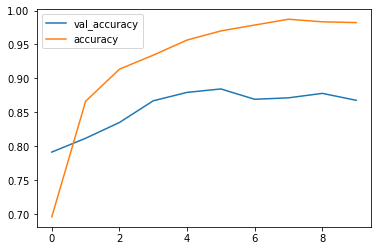

In [18]:
#Wykres dokładności oraz maks dokładnośc w zb. wal.
plt.plot(hist1.history["val_accuracy"], label="val_accuracy")
plt.plot(hist1.history["accuracy"], label="accuracy")
print("Maks val_accuracy:",np.max(hist1.history["val_accuracy"]))
plt.legend()
plt.show()

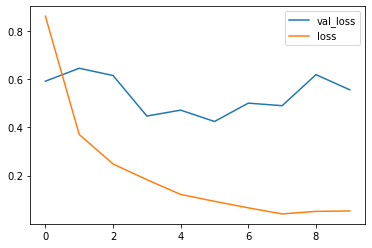

In [19]:
plt.plot(hist1.history["val_loss"], label="val_loss")
plt.plot(hist1.history["loss"], label="loss")
plt.legend()
plt.show()

In [20]:
#funkcja tworząca model wykorzystywana do pobierania checkpkt
def create_model1() :
        CNN = keras.models.Sequential([
        keras.layers.Conv2D(filters = 4, kernel_size= 3, activation = 'relu', input_shape = [150,150,3]), #warstwa wejściowa
        keras.layers.Conv2D(filters = 8, kernel_size= 3, activation = 'relu'), #z każdą kolejną warstwa liczba filtrów zwiększamy dwukrotnie
        keras.layers.Conv2D(filters = 16, kernel_size= 3, activation = 'relu'),
        keras.layers.Conv2D(filters = 32, kernel_size= 3, activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = 2, strides = 2), #zmniejszenie  dwukrotne
        keras.layers.Flatten(), # spłaszczenie danych dwuwymiarowych
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dense(units=8, activation='softmax')]) #warstwa wyjściowa, liczba neuronów odpowiada liczbie klas

        # kompilacja modelu,wybrana z wględu na zaprezentowana na zajęciach
        CNN.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
    
        return CNN;

In [21]:
CNN2 = create_model1() # wywołanie funkcji tworzącej model

In [22]:
CNN2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 4)       112       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 146, 8)       296       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 144, 144, 16)      1168      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 142, 142, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 71, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 161312)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [23]:
hist2 = CNN2.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
173/173 [==============================] - 163s 941ms/step - loss: 1.4190 - accuracy: 0.5424 - val_loss: 0.5368 - val_accuracy: 0.8119
Epoch 2/10
173/173 [==============================] - 164s 950ms/step - loss: 0.3331 - accuracy: 0.8820 - val_loss: 0.3972 - val_accuracy: 0.8526
Epoch 3/10
173/173 [==============================] - 179s 1s/step - loss: 0.1971 - accuracy: 0.9388 - val_loss: 0.3325 - val_accuracy: 0.8787
Epoch 4/10
173/173 [==============================] - 167s 966ms/step - loss: 0.1491 - accuracy: 0.9461 - val_loss: 0.3205 - val_accuracy: 0.8932
Epoch 5/10
173/173 [==============================] - 167s 964ms/step - loss: 0.1094 - accuracy: 0.9671 - val_loss: 0.4275 - val_accuracy: 0.8671
Epoch 6/10
173/173 [==============================] - 165s 956ms/step - loss: 0.0675 - accuracy: 0.9789 - val_loss: 0.3266 - val_accuracy: 0.8962
Epoch 7/10
173/173 [==============================] - 165s 951ms/step - loss: 0.0448 - accuracy: 0.9866 - val_loss: 0.3172 - va

In [24]:
confusion_matrix(np.argmax(CNN2.predict(val_gen),axis=1),val_gen.classes)

array([[128,   1,   4,   5,   3,   0,   0,   0],
       [  2, 187,   0,   1,   0,   0,   0,   0],
       [  4,   1, 144,  34,  11,   0,   0,   0],
       [  3,   1,  26,  96,   6,   0,   0,   0],
       [  8,   1,   2,   2, 147,   0,   2,   0],
       [  0,   0,   0,   0,   1, 200,   0,   0],
       [  0,   2,   0,   0,   0,   0, 155,   0],
       [  0,   0,   1,   2,   0,   0,   0, 197]], dtype=int64)

Maks val_accuracy: 0.9114015698432922


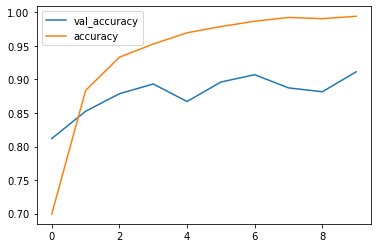

In [25]:
#Wykres dokładności oraz maks dokładnośc w zb. wal.
plt.plot(hist2.history["val_accuracy"], label="val_accuracy")
plt.plot(hist2.history["accuracy"], label="accuracy")
print("Maks val_accuracy:",np.max(hist2.history["val_accuracy"]))
plt.legend()
plt.show()

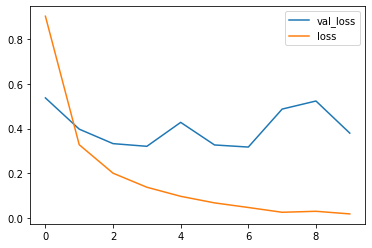

In [26]:
plt.plot(hist2.history["val_loss"], label="val_loss")
plt.plot(hist2.history["loss"], label="loss")
plt.legend()
plt.show()

In [27]:
def create_model2() :
        CNN = keras.models.Sequential([
        keras.layers.Conv2D(filters = 4, kernel_size= 3, activation = 'relu', input_shape = [150,150,3]),
        keras.layers.Conv2D(filters = 8, kernel_size= 3, activation = 'relu'),
        keras.layers.Conv2D(filters = 16, kernel_size= 3, activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = 2, strides = 2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dense(units=8, activation='softmax')])


        CNN.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
    
        return CNN;

In [28]:
CNN3 = create_model2()

In [29]:
CNN3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 4)       112       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 146, 146, 8)       296       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 144, 144, 16)      1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 72, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               10616960  
_________________________________________________________________
dense_5 (Dense)              (None, 8)                

In [30]:
hist3 = CNN3.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
173/173 [==============================] - 108s 613ms/step - loss: 0.9751 - accuracy: 0.6620 - val_loss: 0.3730 - val_accuracy: 0.8686
Epoch 2/10
173/173 [==============================] - 123s 714ms/step - loss: 0.2613 - accuracy: 0.9006 - val_loss: 0.3351 - val_accuracy: 0.8765
Epoch 3/10
173/173 [==============================] - 137s 793ms/step - loss: 0.1600 - accuracy: 0.9379 - val_loss: 0.5271 - val_accuracy: 0.8402
Epoch 4/10
173/173 [==============================] - 141s 813ms/step - loss: 0.1105 - accuracy: 0.9645 - val_loss: 0.3247 - val_accuracy: 0.8962
Epoch 5/10
173/173 [==============================] - 136s 784ms/step - loss: 0.0742 - accuracy: 0.9773 - val_loss: 0.3551 - val_accuracy: 0.8918
Epoch 6/10
173/173 [==============================] - 151s 875ms/step - loss: 0.0568 - accuracy: 0.9817 - val_loss: 0.2837 - val_accuracy: 0.9129
Epoch 7/10
173/173 [==============================] - 131s 759ms/step - loss: 0.0593 - accuracy: 0.9811 - val_loss: 0.3241 -

In [31]:
confusion_matrix(np.argmax(CNN3.predict(val_gen),axis=1),val_gen.classes)

array([[128,   1,   3,   1,   1,   0,   1,   0],
       [  2, 190,   2,   0,   1,   0,   2,   0],
       [  1,   0, 137,  25,   3,   0,   0,   0],
       [  2,   1,  28, 104,   3,   0,   0,   0],
       [  9,   0,   4,   6, 159,   0,   2,   0],
       [  1,   0,   0,   0,   1, 200,   0,   0],
       [  2,   1,   3,   2,   0,   0, 152,   0],
       [  0,   0,   0,   2,   0,   0,   0, 197]], dtype=int64)

Maks val_accuracy: 0.9273783564567566


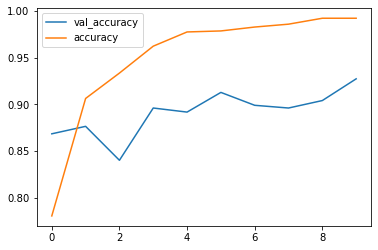

In [32]:
#Wykres dokładności oraz maks dokładnośc w zb. wal.
plt.plot(hist3.history["val_accuracy"], label="val_accuracy")
plt.plot(hist3.history["accuracy"], label="accuracy")
print("Maks val_accuracy:",np.max(hist3.history["val_accuracy"]))
plt.legend()
plt.show()

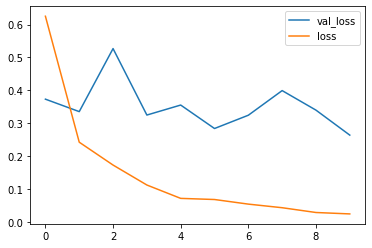

In [33]:
plt.plot(hist3.history["val_loss"], label="val_loss")
plt.plot(hist3.history["loss"], label="loss")
plt.legend()
plt.show()

Wykres dokładności wszystkich modeli (val_accuracy)


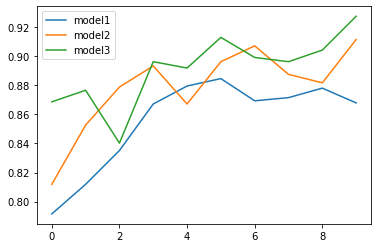

In [43]:
print("Wykres dokładności wszystkich modeli (val_accuracy)")
plt.plot(hist1.history["val_accuracy"], label="model1")
plt.plot(hist2.history["val_accuracy"], label="model2")
plt.plot(hist3.history["val_accuracy"], label="model3")
plt.legend()
plt.show()

Wykres dokładności wszystkich modeli (accuracy)


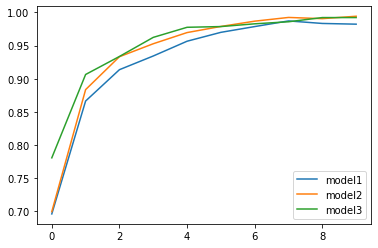

In [44]:
print("Wykres dokładności wszystkich modeli (accuracy)")
plt.plot(hist1.history["accuracy"], label="model1")
plt.plot(hist2.history["accuracy"], label="model2")
plt.plot(hist3.history["accuracy"], label="model3")
plt.legend()
plt.show()

Wykres straty wszystkich modeli (val_loss)


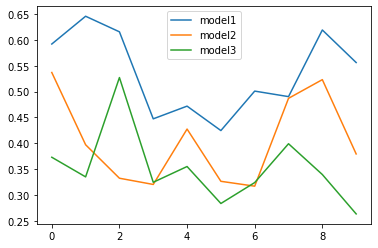

In [45]:
print("Wykres straty wszystkich modeli (val_loss)")
plt.plot(hist1.history["val_loss"], label="model1")
plt.plot(hist2.history["val_loss"], label="model2")
plt.plot(hist3.history["val_loss"], label="model3")
plt.legend()
plt.show()

Wykres straty wszystkich modeli (loss)


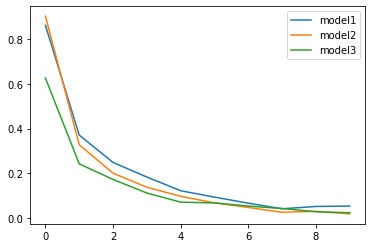

In [46]:
print("Wykres straty wszystkich modeli (loss)")
plt.plot(hist1.history["loss"], label="model1")
plt.plot(hist2.history["loss"], label="model2")
plt.plot(hist3.history["loss"], label="model3")
plt.legend()
plt.show()